In [1]:
import numpyro
import numpy as np 
from jax import random

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [14]:
# Using ChatGPT to generate "fake" data for short heavy people

# Set the number of people
n_people = 30

# Generate true heights and weights
# Hyperprior for height (Mean = 145 cm, Std = 7 cm for short people)
heights_true = np.random.normal(loc=145, scale=7, size=n_people)  
# Hyperprior for weight (Mean = 85 kg, Std = 15 kg for heavy individuals)
weights_true = np.random.normal(loc=85, scale=15, size=n_people)   

# Add uncertainty to the observed heights and weights (±10 cm or kg uncertainty)
heights_observed = heights_true + np.random.randn(n_people) * 10  # Uncertainty in height (±10 cm)
weights_observed = weights_true + np.random.randn(n_people) * 10  # Uncertainty in weight (±10 kg)

# Display the data
data = list(zip(heights_observed, weights_observed))
data




[(148.18223034068245, 109.13139665420437),
 (128.432836001179, 99.77274169332077),
 (137.05824684005958, 68.64455328778278),
 (127.80648553173023, 88.67739665016695),
 (155.92911098871096, 72.62113511363687),
 (147.12951586892217, 95.38645478019275),
 (140.5116249122186, 71.70424702379705),
 (127.3235581907991, 81.53911619483853),
 (140.0994251839755, 86.20258469034182),
 (141.41883543853655, 82.88796540204382),
 (125.24444567841172, 111.72457275116938),
 (124.38859862297723, 92.92112436076007),
 (150.11556951068349, 80.85346808083085),
 (125.35482141423253, 93.63979304114311),
 (142.19702679288898, 106.00393109429143),
 (145.9714576400475, 106.39323655083797),
 (115.40543617824676, 76.53053592076002),
 (145.40217543339693, 77.5503703212949),
 (137.02747632443453, 94.86571090969645),
 (145.63188437313585, 101.85331595634034),
 (146.1082592503341, 76.58103716892484),
 (155.2419947738359, 69.66046190743437),
 (161.8202125508871, 89.16676545184188),
 (136.44914253717263, 82.51066691637978

In [15]:
def model(observed_heights=[], observed_weights=[]):
    with numpyro.plate('plate_i', n_people):
        height = numpyro.sample('height', dist.Normal(170, 10))
        weight = numpyro.sample('weight', dist.Normal(70, 15))
        
    if len(observed_heights) > 1 and len(observed_weights) > 1:
        with numpyro.plate('data', n_people):
        # Sample the observed heights and weights
            numpyro.sample('obs_height', dist.Normal(height, 5.0), obs=observed_heights)
            numpyro.sample('obs_weight', dist.Normal(weight, 5.0), obs=observed_weights)

In [16]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1506.56it/s, 7 steps of size 4.67e-01. acc. prob=0.88]


array([[<Axes: title={'center': 'height'}>,
        <Axes: title={'center': 'height'}>],
       [<Axes: title={'center': 'weight'}>,
        <Axes: title={'center': 'weight'}>]], dtype=object)

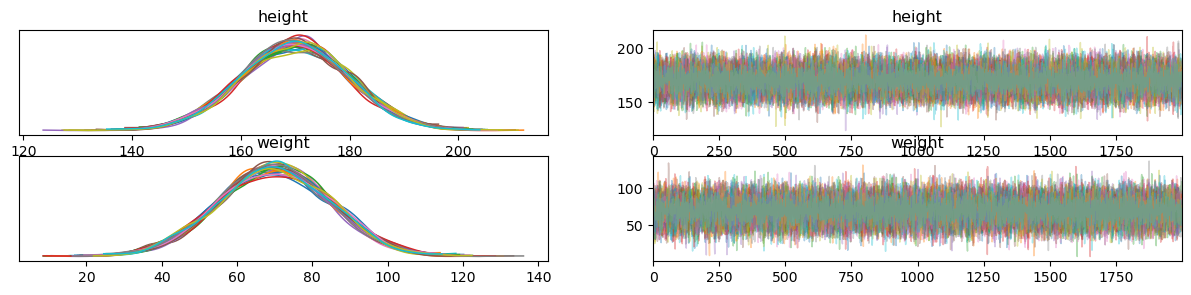

In [17]:
import arviz as az


data = az.from_numpyro(mcmc)

# Plot the trace for both 'height' and 'weight'
az.plot_trace(data, compact=True, figsize=(15, 3))



In [18]:
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, data)

posterior_samples = b_mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1491.89it/s, 7 steps of size 4.67e-01. acc. prob=0.88]


array([[<Axes: title={'center': 'height'}>,
        <Axes: title={'center': 'height'}>]], dtype=object)

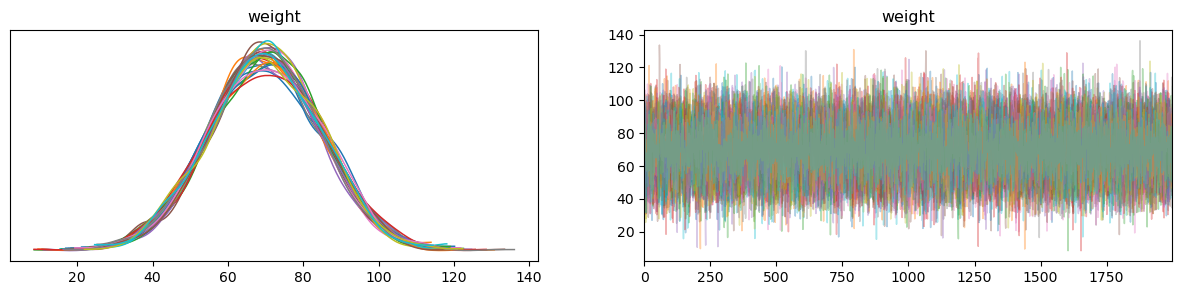

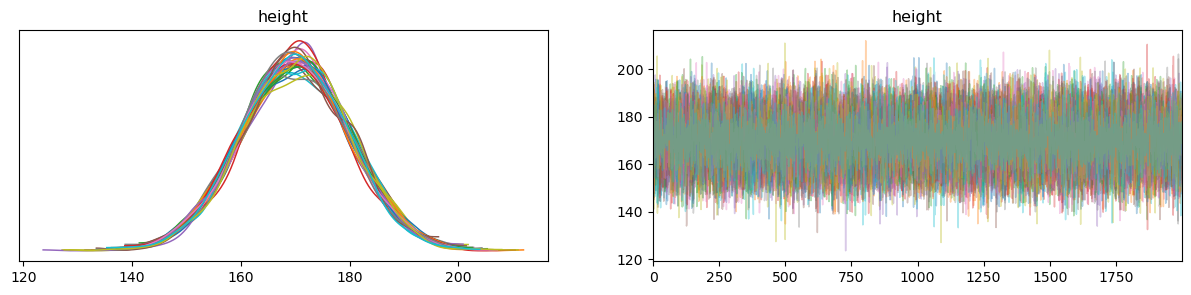

In [19]:
data = az.from_numpyro(b_mcmc)
az.plot_trace(data, var_names=['weight'], compact=True, figsize=(15, 3))
az.plot_trace(data, var_names=['height'], compact=True, figsize=(15, 3))

In [20]:
def HBmodel(observed_heights=[], observed_weights=[]):
    mean_height = numpyro.sample('mean_height', dist.Normal(145, 7))
    mean_weight = numpyro.sample('mean_weight', dist.Normal(85, 15))
    
    with numpyro.plate('plate_i', n_people):
        height_ = numpyro.sample('height_', dist.Normal(mean_height, 1.0))
        weight_ = numpyro.sample('weight_', dist.Normal(mean_weight, 1.0))
        height = numpyro.deterministic('height', mean_height + height_)
        weight = numpyro.deterministic('weight', mean_weight + weight_)
        
    if len(observed_heights) > 1 and len(observed_weights) > 1:
        with numpyro.plate('data', n_people):
            numpyro.sample('obs_height', dist.Normal(height, 5.0), obs=observed_heights)
            numpyro.sample('obs_weight', dist.Normal(weight, 5.0), obs=observed_weights)

In [21]:
nuts_kernel = NUTS(HBmodel)

hbm_mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=4000)
rng_key = random.PRNGKey(0)
hbm_mcmc.run(rng_key, data)

posterior_samples = hbm_mcmc.get_samples()

sample: 100%|██████████| 8000/8000 [00:15<00:00, 525.81it/s, 63 steps of size 1.01e-02. acc. prob=0.96]   


In [22]:
hbm_mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
   height_[0]    142.47      6.43    142.14    131.87    152.41     18.29      1.00
   height_[1]    142.47      6.44    142.25    131.15    151.93     18.24      1.00
   height_[2]    142.46      6.41    142.20    131.98    152.71     18.25      1.00
   height_[3]    142.48      6.43    142.11    131.88    152.61     18.33      1.00
   height_[4]    142.45      6.41    142.15    131.34    152.31     18.25      1.00
   height_[5]    142.47      6.41    142.17    131.24    152.03     18.29      1.00
   height_[6]    142.46      6.42    142.21    131.77    152.62     18.06      1.00
   height_[7]    142.48      6.42    142.28    131.85    152.42     18.24      1.00
   height_[8]    142.51      6.41    142.24    131.86    152.45     18.23      1.00
   height_[9]    142.47      6.39    142.20    131.38    152.00     18.31      1.00
  height_[10]    142.47      6.40    142.13    131.30    152.14     18.30  

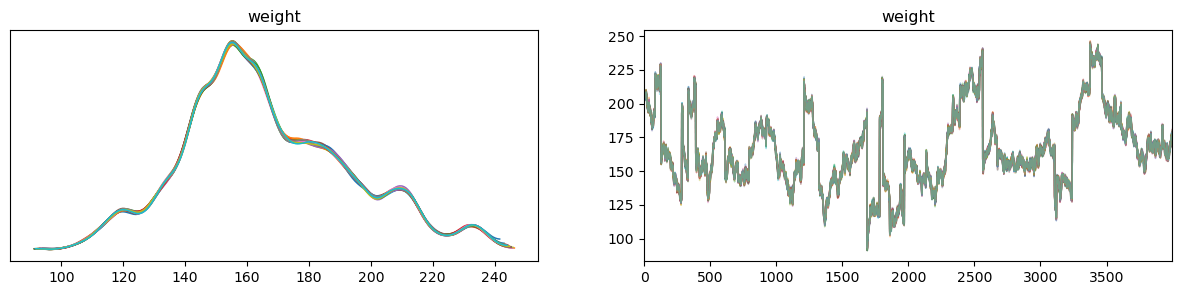

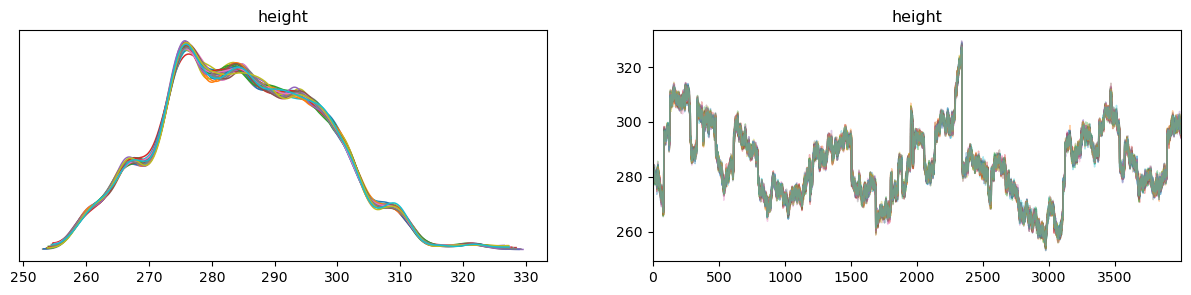

In [23]:
hbm_data = az.from_numpyro(hbm_mcmc)
az.plot_trace(hbm_data, var_names=['weight'], compact=True, figsize=(15, 3));
az.plot_trace(hbm_data, var_names=['height'], compact=True, figsize=(15, 3));
